### Setup parameters, functions etc.

In [1]:
#import modules
import numpy as np
import matplotlib.pyplot as plot
import matplotlib.cm as cmap


def getLoanInterest(salary,rpi=0.024):
    # lowest interest rate
    lim0=25725
    # highest interest rate
    lim1=46305
    # max increase above rpi
    maxinc=0.03
    if salary < lim0:
        interest=rpi
    elif salary >=lim1:
        interest=rpi+maxinc
    else:
        interest = rpi + maxinc * (salary-lim0)/(lim1-lim0)
    return interest

def getLoanRepayment(salary,year=0,cpi=0.019,gradTax=False):
    # repayment threshold
    lim0=25000 * (1+cpi)**year
    # repayment rate
    rate=0.09
    # set repayment timelimit
    timelim=40
    if year>40 and gradTax==False:
        # over time limit. no repayment
        repay=0
    elif salary<=lim0:
        # salary bewlow threshold. no repayment
        repay=0
    else:
        # repay at <rate> on salary above <lim0>
        repay = rate * (salary-lim0)
    return(repay)

def removeInflation(costIn,years=[],inflation=0.19):
    if len(years)==0:
        years=arange(len(costIn))
    costOut=np.zeros_like(costIn)
    for y in range(len(years)):
        costOut[y]=costIn[y] / (1+inflation)**years[y]
    return costOut

# set salary profiles parameters
def getSalary(year,name,interest=0.019):
    if name=='avg':
        salary=25000 + 1000*year
        salary=np.min([45000,salary])
    elif name=='low':
        salary=20000 + 750*year
        salary=np.min([30000,salary])
    elif name=='high':
        salary=25000 + 2000*year
    elif name=='vhigh':
        salary=25000 * 2**(year/10)
    else:
        salary=int(name.split('k')[0])*1000
    
    #apply interest
    salary = salary * (1+interest)**year
    return salary

# function to compute repayments
def calcRepayments(dataIn,cpi=0.019,rpi=0.024,gradTax=False,initloan=40000):
    if not 'year' in dataIn:
        dataIn['year']=np.arange(0,41)
    if not 'salary' in dataIn:
        dataIn['salary']=np.zeros_like(dataIn['year'])
        for y in range(len(dataIn['year'])):
            dataIn['salary'][y]=getSalary(dataIn['year'][y],p)
    dataIn['loan']=np.zeros_like(dataIn['year'])
    dataIn['interest']=np.zeros_like(dataIn['year'])
    dataIn['repayment']=np.zeros_like(dataIn['year'])
    dataIn['repayment-total']=np.zeros_like(dataIn['year'])
    
    for y in range(len(dataIn['year'])):
        if y==0:
            # set initial value
            dataIn['loan'][0]=initloan
        else:
            # take of previous repayment
            dataIn['loan'][y] = dataIn['loan'][y-1] - dataIn['repayment'][y-1]
            if dataIn['loan'][y]>0:
                # add on interest
                dataIn['interest'][y] = dataIn['loan'][y] * getLoanInterest(dataIn['salary'][y])
                dataIn['loan'][y] = dataIn['loan'][y] + dataIn['interest'][y]
            # calculate new repayment
            dataIn['repayment'][y] = getLoanRepayment(dataIn['salary'][y],y,gradTax=gradTax)
            dataIn['repayment'][y] = np.min([dataIn['repayment'][y],dataIn['loan'][y]])
        # calculate total repayments to date
        dataIn['repayment-total'][y] = dataIn['repayment-total'][y-1] + dataIn['repayment'][y]
        # convert to inflation-free quantities
    dataIn['salary-noinf'] = removeInflation(dataIn['salary'],dataIn['year'],inflation=cpi)
    dataIn['loan-noinf'] = removeInflation(dataIn['loan'],dataIn['year'],inflation=cpi)
    dataIn['interest-noinf'] = removeInflation(dataIn['interest'],dataIn['year'],inflation=cpi)
    dataIn['repayment-noinf'] = removeInflation(dataIn['repayment'],dataIn['year'],inflation=cpi)
    dataIn['effectiveTax'] = dataIn['repayment'] / dataIn['salary']
    dataIn['avgSalary'] = np.mean(dataIn['salary'])
    dataIn['totalSalary'] = np.mean(dataIn['salary'])
    return dataIn

### Set initial values

In [2]:
# set loan initial values
fees_yr=7250
subsistence_yr=5000
initloan = (fees_yr + subsistence_yr)*3

#### Assumptions
 * RPI = fixed 2.4%
 * CPI = fixed at 1.9%
 * Salaries increase with CPI
 * Loan interest charged at RPI below £25725, RPI+3% above £46305, linearly scaled between the two
 * Repayments charged at 9% of earnings above £25000
 * Interest starts at graduation
 * Total loan is £36750


### Compute values

In [3]:
colmap= cmap.get_cmap('gist_heat')

data={'avg':{'col':'k','gradTax':False,'desc':'Average salary profile','type':'profile'},
      'low':{'col':'g','gradTax':False,'desc':'Low salary profile','type':'profile'},
      'high':{'col':'b','gradTax':False,'desc':'High salary profile','type':'profile'},
      'vhigh':{'col':'r','gradTax':False,'desc':'Very high salary profile','type':'profile'},
      '25k':{'col':colmap(0.1),'gradTax':False,'desc':'£25k flat','type':'flat'},
      '30k':{'col':colmap(0.2),'gradTax':False,'desc':'£30k flat','type':'flat'},
      '35k':{'col':colmap(0.3),'gradTax':False,'desc':'£35k flat','type':'flat'},
      '40k':{'col':colmap(0.4),'gradTax':False,'desc':'£40k flat','type':'flat'},
      '45k':{'col':colmap(0.5),'gradTax':False,'desc':'£45k flat','type':'flat'},
      '50k':{'col':colmap(0.6),'gradTax':False,'desc':'£50k flat','type':'flat'},
      '55k':{'col':colmap(0.7),'gradTax':False,'desc':'£55k flat','type':'flat'},
      '60k':{'col':colmap(0.8),'gradTax':False,'desc':'£60k flat','type':'flat'},
      '100k':{'col':colmap(0.9),'gradTax':False,'desc':'£100k flat','type':'flat'},
      '150k':{'col':colmap(1.0),'gradTax':False,'desc':'£150k flat','type':'flat'},
     }
for p in data:
    data[p]=calcRepayments(data[p],gradTax=data[p].get('gradTax',False),initloan=initloan)

### Make plots

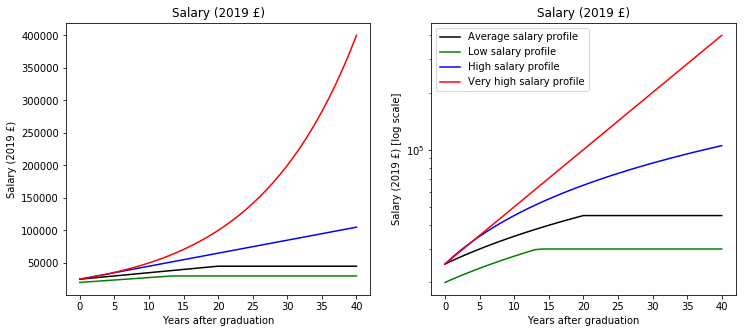

In [4]:
plot.figure(figsize=(12,5))
plot.subplot(1,2,1)
for p in data:
    if data[p]['type']=='profile':
        plot.plot(data[p]['year'],data[p]['salary-noinf'],label=data[p]['desc'],c=data[p].get('col',None),ls=data[p].get('ls','-'))
plot.title('Salary (2019 £)')
plot.ylabel('Salary (2019 £)')
plot.xlabel('Years after graduation')

plot.subplot(1,2,2)
for p in data:
    if data[p]['type']=='profile':
        plot.plot(data[p]['year'],data[p]['salary-noinf'],label=data[p]['desc'],c=data[p].get('col',None),ls=data[p].get('ls','-'))
plot.title('Salary (2019 £)')
plot.ylabel('Salary (2019 £) [log scale]')
plot.xlabel('Years after graduation')
plot.yscale('log')
plot.legend()
plot.savefig('salary_profiles.png')

#### Description:
**Low salary profile: Starts at £20k, Rises £750/decade (+ inflation), capped at £30k**

**Average salary profile: Starts at £25k, Rises £10k/decade (+ inflation), capped at £45k**

**High salary profile: Starts at £25k, Rises £2k/decade (+ inflation), uncapped**

**Very high salary proile: Starta at £25k, doubles each decade (+ inflation), uncapped**


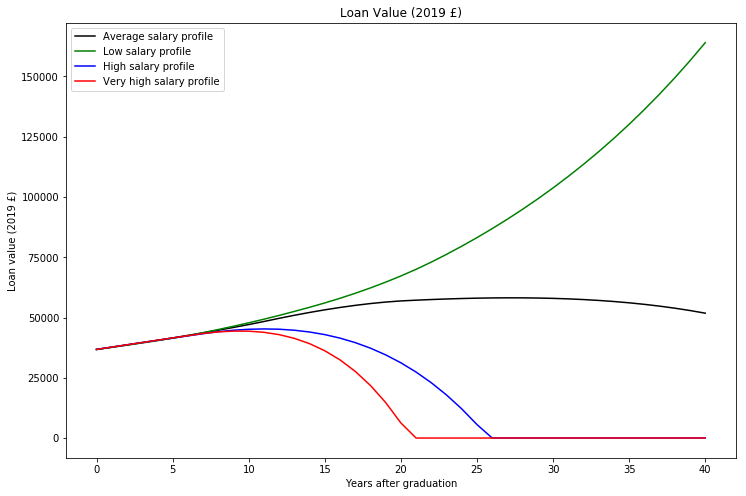

In [5]:
plot.figure(figsize=(12,8))
for p in data:
    if data[p]['type']=='profile':
        plot.plot(data[p]['year'],data[p]['loan'],label=data[p]['desc'],c=data[p].get('col',None),ls=data[p].get('ls','-'))
plot.title('Loan Value (2019 £)')
plot.xlabel('Years after graduation')
plot.ylabel('Loan value (2019 £)')
plot.legend()
plot.savefig('loan-value_profiles.png')

#### Description:
**The more you earn, the faster you pay off your loan.**

/Applications/anaconda3/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


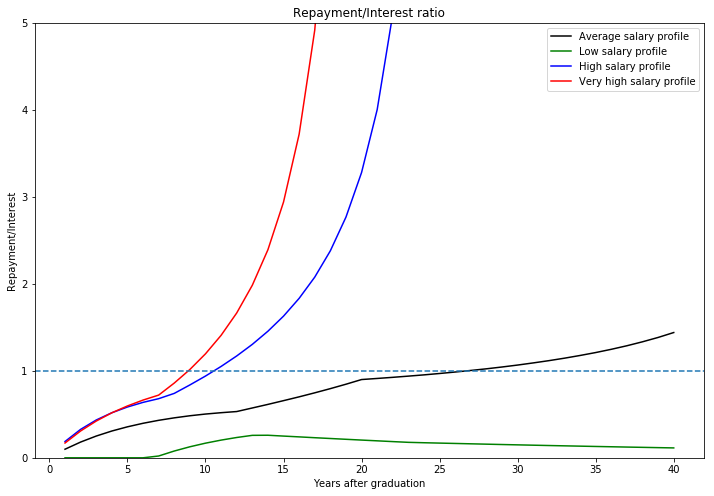

In [6]:
plot.figure(figsize=(12,8))
for p in data:
    if data[p]['type']=='profile':
        plot.plot(data[p]['year'],data[p]['repayment']/data[p]['interest'],label=data[p]['desc'],c=data[p].get('col',None),ls=data[p].get('ls','-'))
plot.title('Repayment/Interest ratio')
plot.xlabel('Years after graduation')
plot.ylabel('Repayment/Interest')
plot.ylim(0,5)
plot.legend()
plot.axhline(1.0,ls='--')
plot.savefig('loan-vrepay_ratio_profiles.png')

#### Description:
**The "average" profile only just starts meeting the interest after ~30 years. Low earners don't every touch the interest.**

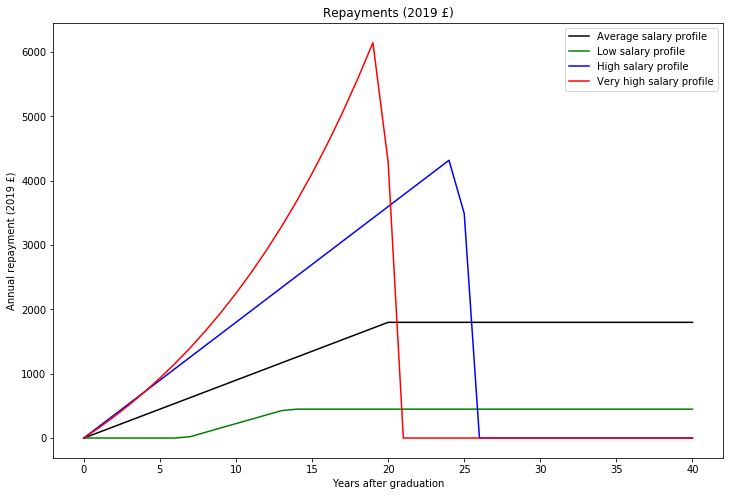

In [7]:
plot.figure(figsize=(12,8))
for p in data:
    if data[p]['type']=='profile':
        plot.plot(data[p]['year'],data[p]['repayment-noinf'],label=data[p]['desc'],c=data[p].get('col',None),ls=data[p].get('ls','-'))
#     plot.plot(data[p]['year'],data[p]['interest-noinf'],label=p+' (Interest)',c=data[p].get('col',None),ls='--')
plot.title('Repayments (2019 £)')
plot.ylabel('Annual repayment (2019 £)')
plot.xlabel('Years after graduation')
plot.legend()
plot.savefig('payments_profiles.png')

#### Description:
**As expected, higher earnings pay more per year**

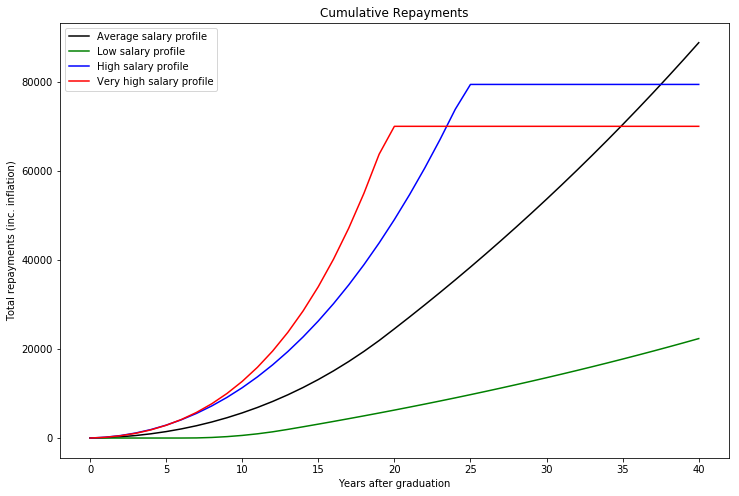

In [8]:
plot.figure(figsize=(12,8))
for p in data:
    if data[p]['type']=='profile':
        plot.plot(data[p]['year'],data[p]['repayment-total'],label=data[p]['desc'],c=data[p]['col'])
#     plot.plot(data[p]['year'],data[p]['interest-noinf'],label=p+' (Interest)',c=data[p]['col'],ls='--')
plot.title('Cumulative Repayments')
plot.xlabel('Years after graduation')
plot.ylabel('Total repayments (inc. inflation)')
plot.legend()
plot.savefig('cumulative_payments_profiles.png')

#### Description
**Those who pay the most in total are the Average earners. Above that, the more you earn the less you pay.**

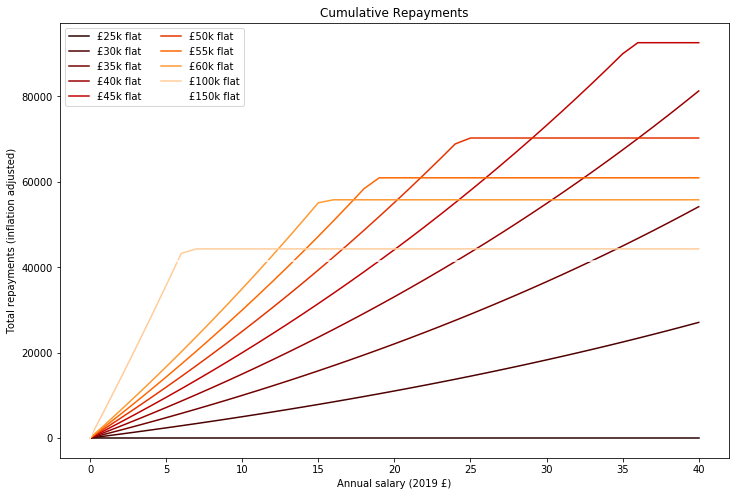

In [9]:
plot.figure(figsize=(12,8))
for p in data:
    if data[p]['type']=='flat':
        plot.plot(data[p]['year'],data[p]['repayment-total'],label=data[p]['desc'],c=data[p]['col'])
#     plot.plot(data[p]['year'],data[p]['interest-noinf'],label=p+' (Interest)',c=data[p]['col'],ls='--')
plot.title('Cumulative Repayments')
plot.ylabel('Total repayments (inflation adjusted)')
plot.xlabel('Annual salary (2019 £)')
plot.legend(ncol=2)
plot.savefig('cumulative_payments.png')

#### Description:
**For flat salaries (with inflation), peak payments are for £45k. Above that, you pay less the more you earn. The turnover is effectively the point at which a graduate pays off the full loan value.**

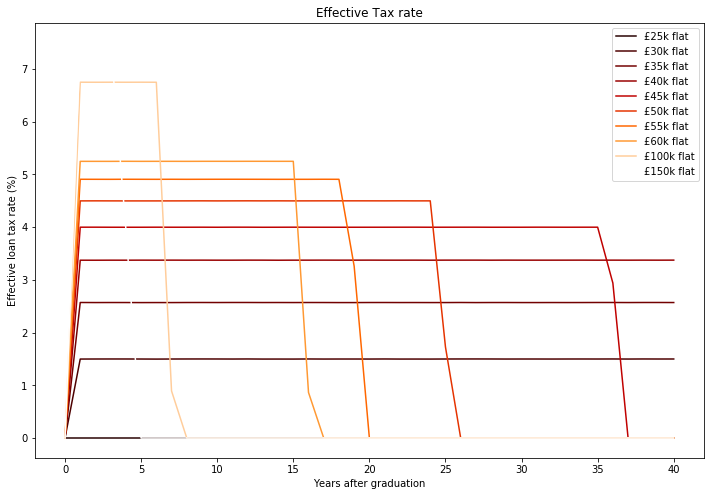

In [10]:
plot.figure(figsize=(12,8))
for p in data:
    if data[p]['type']=='flat':
        plot.plot(data[p]['year'],data[p]['effectiveTax']*100,label=data[p]['desc'],c=data[p]['col'])
#     plot.plot(data[p]['year'],data[p]['interest-noinf'],label=p+' (Interest)',c=data[p]['col'],ls='--')
plot.title('Effective Tax rate')
plot.ylabel('Effective loan tax rate (%)')
plot.xlabel('Years after graduation')
plot.legend()
plot.savefig('effective_tax.png')

#### Description
**The effective tax rate is higher the more you earn, since it only affects earnings over £25k, but is paid for less time if you earn more.**

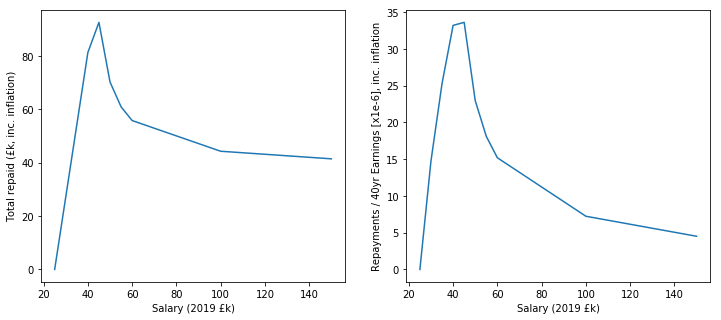

In [11]:
salaries=[]
repayments=[]
totalsalary=[]
fracpay=[]
for p in data:
    if data[p]['type']=='flat':
        salaries.append(data[p]['salary-noinf'][-1]/1e3)
        totalsalary.append(np.sum(data[p]['salary']))
        repayments.append(data[p]['repayment-total'][-1]/1e3)

plot.figure(figsize=(12,5))
plot.subplot(1,2,1)
plot.plot(salaries,repayments)
#     plot.plot(data[p]['year'],data[p]['interest-noinf'],label=p+' (Interest)',c=data[p]['col'],ls='--')
plot.ylabel('Total repaid (£k, inc. inflation)')
plot.xlabel('Salary (2019 £k)')

plot.subplot(1,2,2)
plot.plot(salaries,np.array(repayments)/np.array(totalsalary)*1e6)
plot.ylabel('Repayments / 40yr Earnings [x1e-6], inc. inflation')
plot.xlabel('Salary (2019 £k)')
plot.savefig('salary_repayments.png')

#### Description
**Above about £45k, the more you earn the less you pay off, whether in terms of total amount or earnings over 40 years.**

In [12]:
cmap.get_cmap('gist_heat')

ValueError: Colormap kj is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Vega10, Vega10_r, Vega20, Vega20_r, Vega20b, Vega20b_r, Vega20c, Vega20c_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spectral, spectral_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r